In [1]:
import pandas as pd
import numpy as np
import os
from pcntoolkit.dataio.fileio import load as ptkload
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import matplotlib as mpl
from pathlib  import Path
from pcntoolkit.dataio.fileio import save_nifti
from pcntoolkit.dataio.fileio import save as ptksave

# globals
root_dir = '/project_cephfs/3022017.06/ENIGMA_ANX/'
proc_dir = os.path.join(root_dir,'Z_stat/')
data_dir = os.path.join(proc_dir,'data/')
w_dir = os.path.join(proc_dir,'vox/')
mask_nii = ('/opt/fmriprep/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz')
ex_nii = os.path.join(data_dir, 'ENIGMA_FC_tr_1.nii.gz')

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load in the Z_est files
Z_est_control_test = ptkload(os.path.join(w_dir,'Z_estimate.pkl'), mask=mask_nii)
Z_est_clinical = ptkload(os.path.join(w_dir,'Z_predcl.pkl'), mask=mask_nii)
Full_sample_deviations = np.append(Z_est_control_test,Z_est_clinical, axis = 0)

#Load in the diagnosis data
Principal_diagnosis_current = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/all_test_validation.csv', usecols = ['Principal_diagnosis_current']) 

#REPLACE ALL NOT AVAILABLE with NA
Principal_diagnosis_current.replace(to_replace='not assessed/not available', value='NA', regex=True, inplace=True)
Principal_diagnosis_current.replace(to_replace='not available', value='NA', regex=True, inplace=True)
Principal_diagnosis_current.replace(to_replace='not applicable', value='NA', regex=True, inplace=True)

#Mask by participants for whom diagnosis data is available + included
mask_PD = Principal_diagnosis_current['Principal_diagnosis_current'].notna() #remove NAs
mask_exclude_diagnosis = ~Principal_diagnosis_current['Principal_diagnosis_current'].isin(['others', 'schizophrenia', 'specific phobia', 'panic disorder', 'major depressive disorder']) #and remove others and schizophrenia
combined_mask = mask_PD & mask_exclude_diagnosis

PDC_vals = Principal_diagnosis_current[combined_mask].to_numpy()
PDC_sample_deviations = Full_sample_deviations[combined_mask]

In [3]:
# Recode the data into integers for classification
mapping = {'ptsd': 1, 'gad': 2, 'sad': 3, 'ocd': 4}
# Recode the data using list comprehension
PDC_vals = [[mapping[item[0]]] for item in PDC_vals]
PDC_vals = np.array(PDC_vals)

print(len(PDC_vals))

202


In [4]:
#Define parameters
X1 = PDC_sample_deviations #Deviations
y = PDC_vals.ravel()
n_samples, n_features = X1.shape
random_state = np.random.RandomState(0)

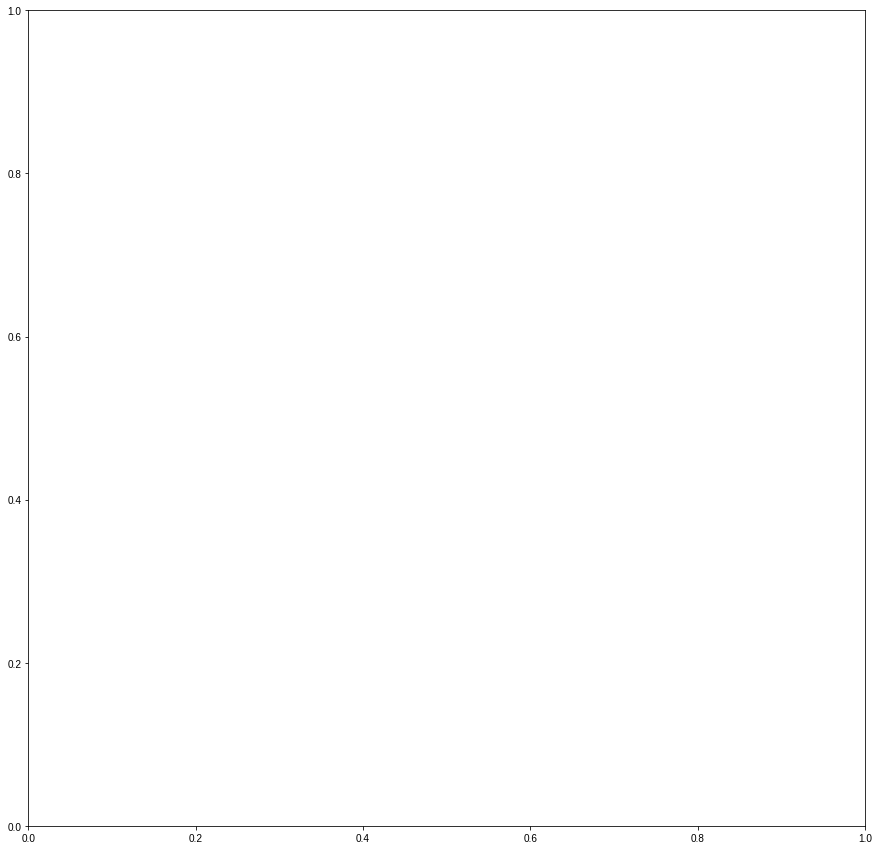

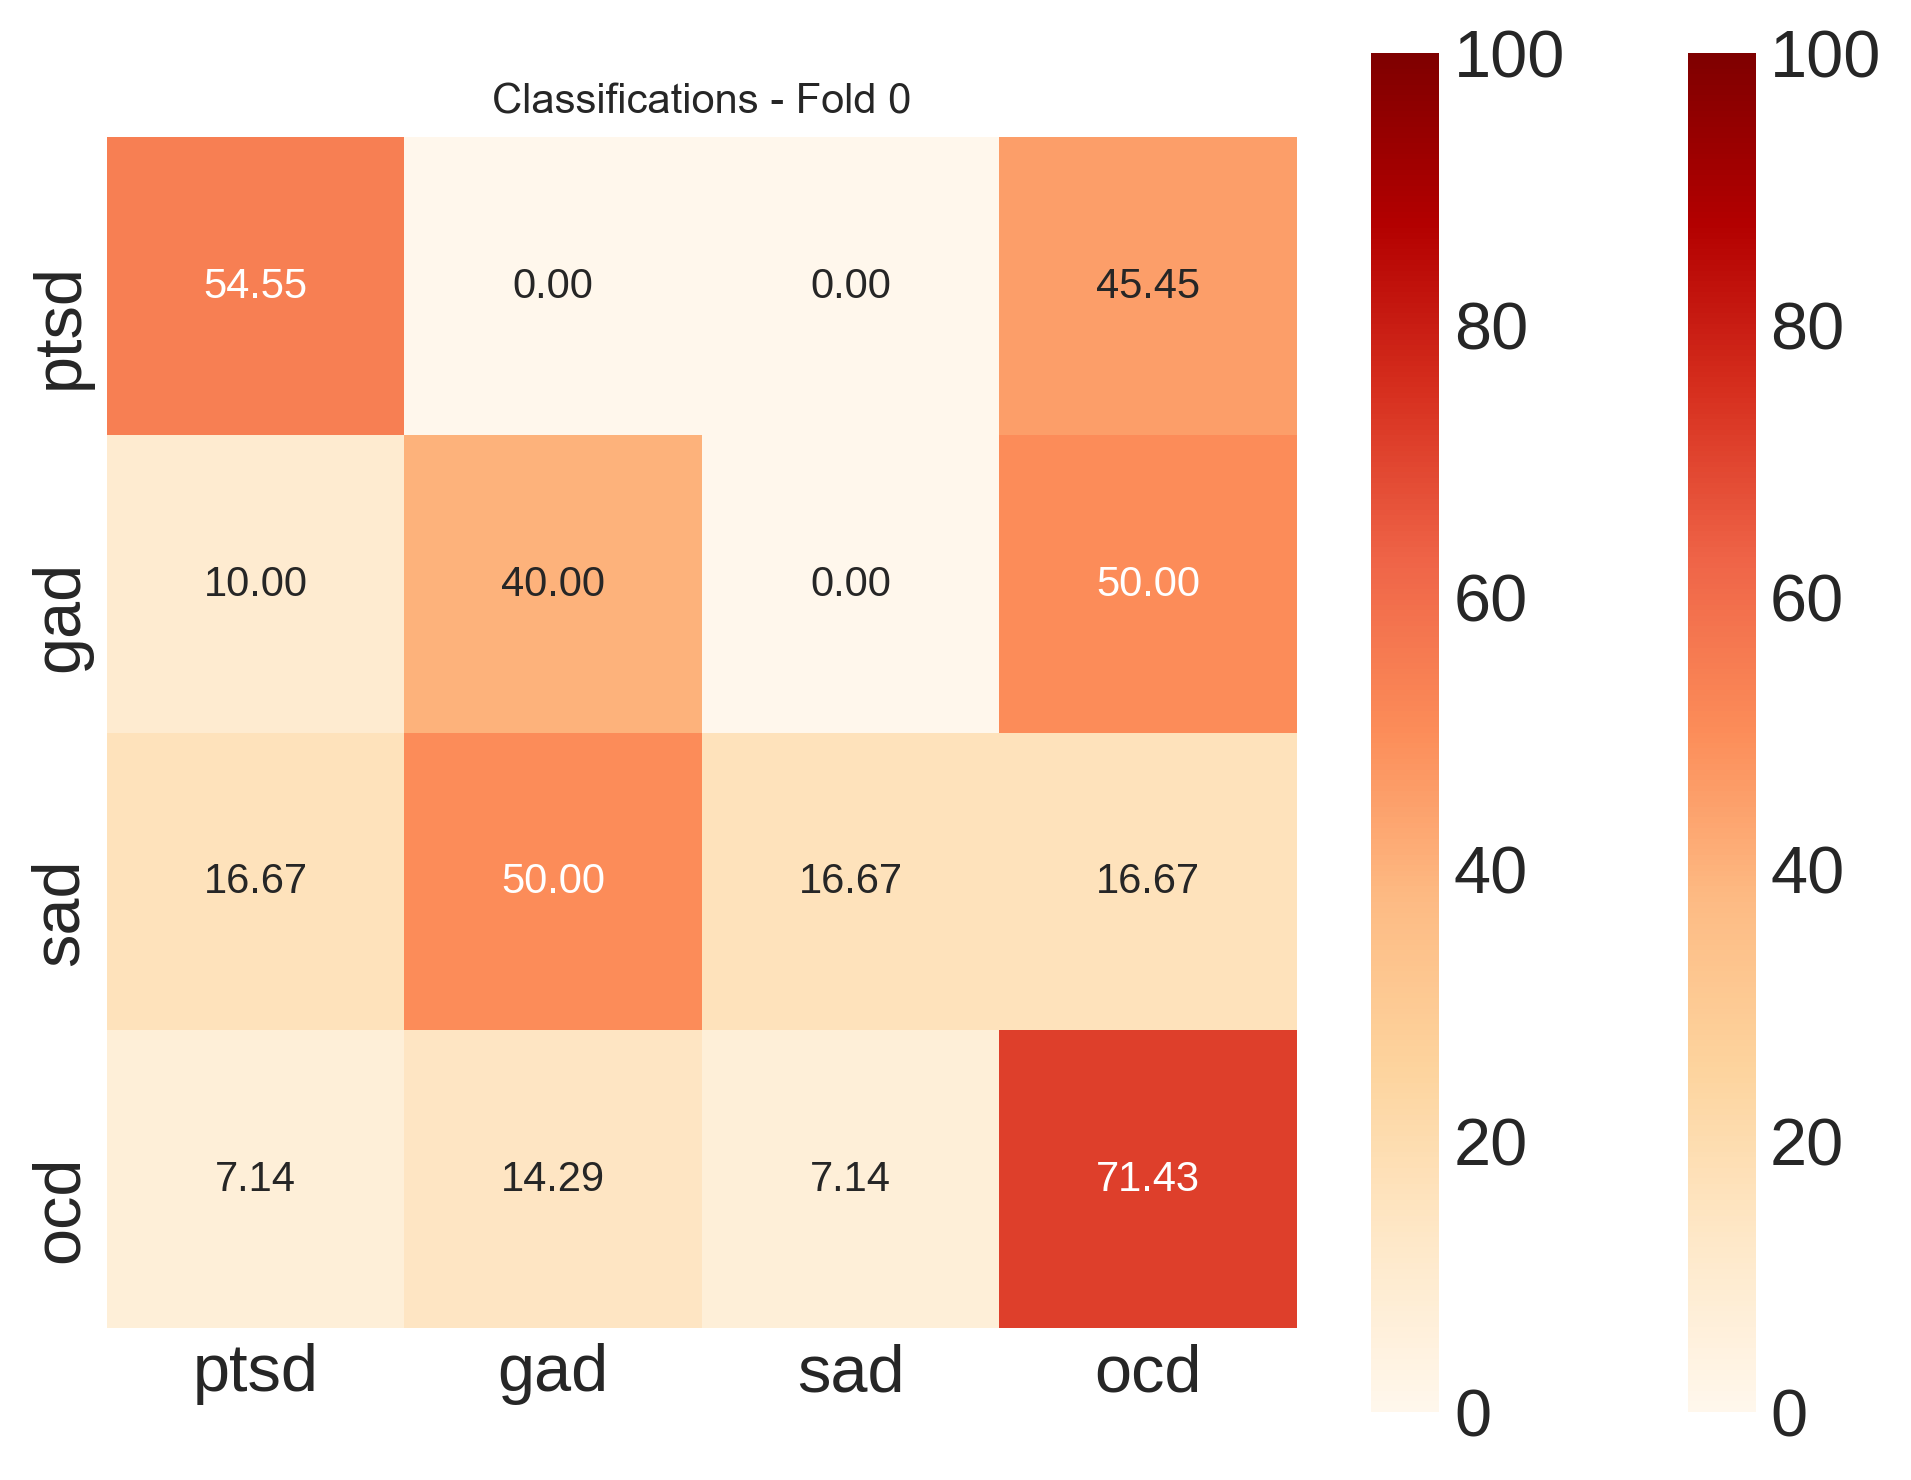

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


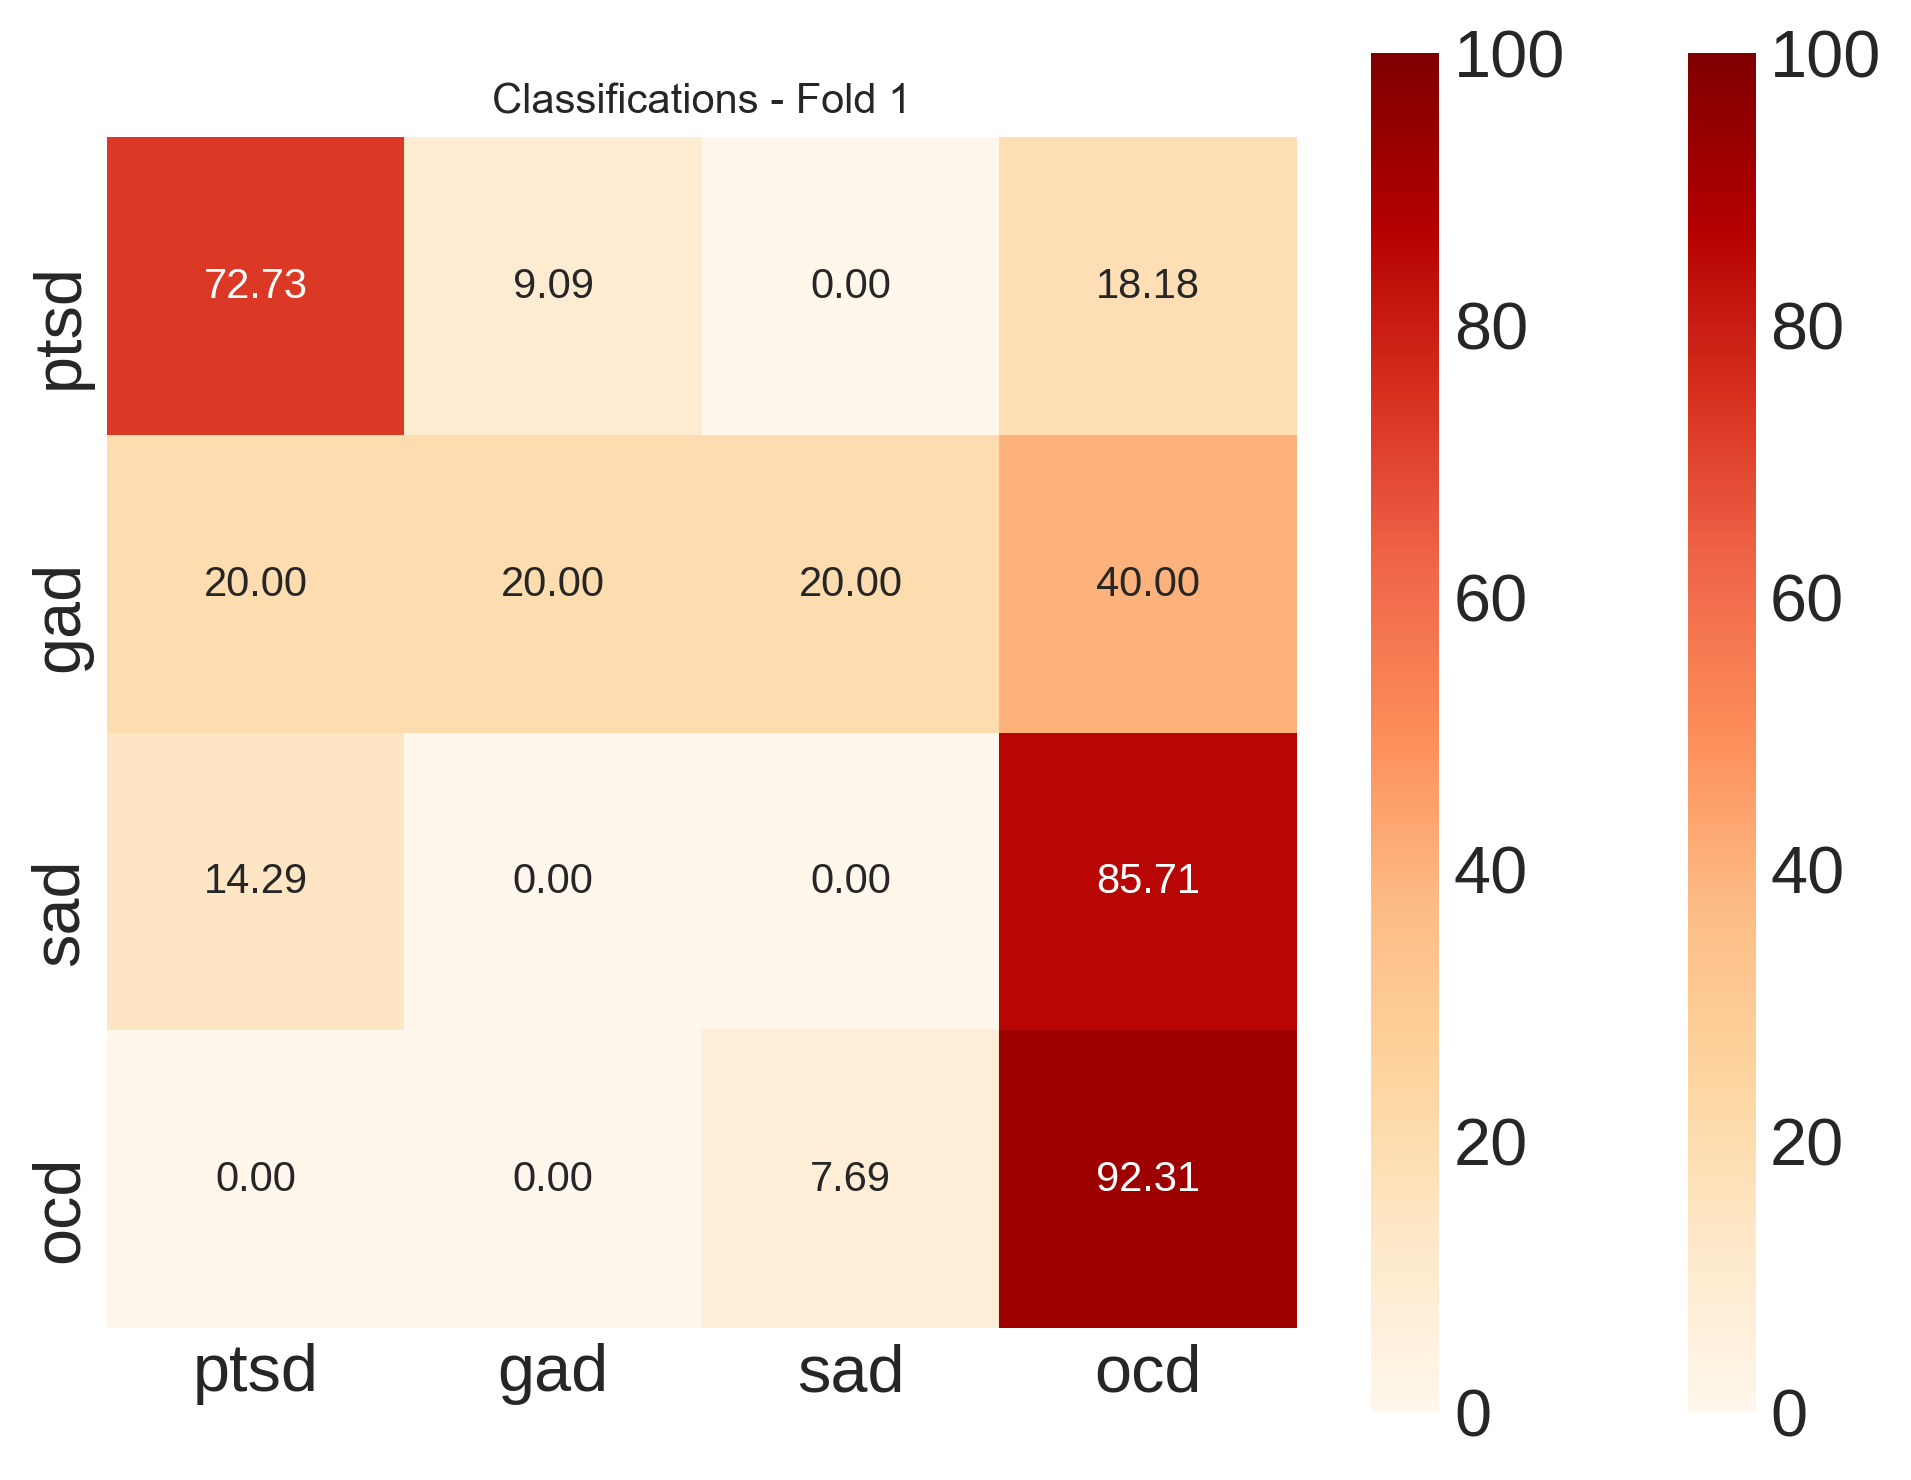

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


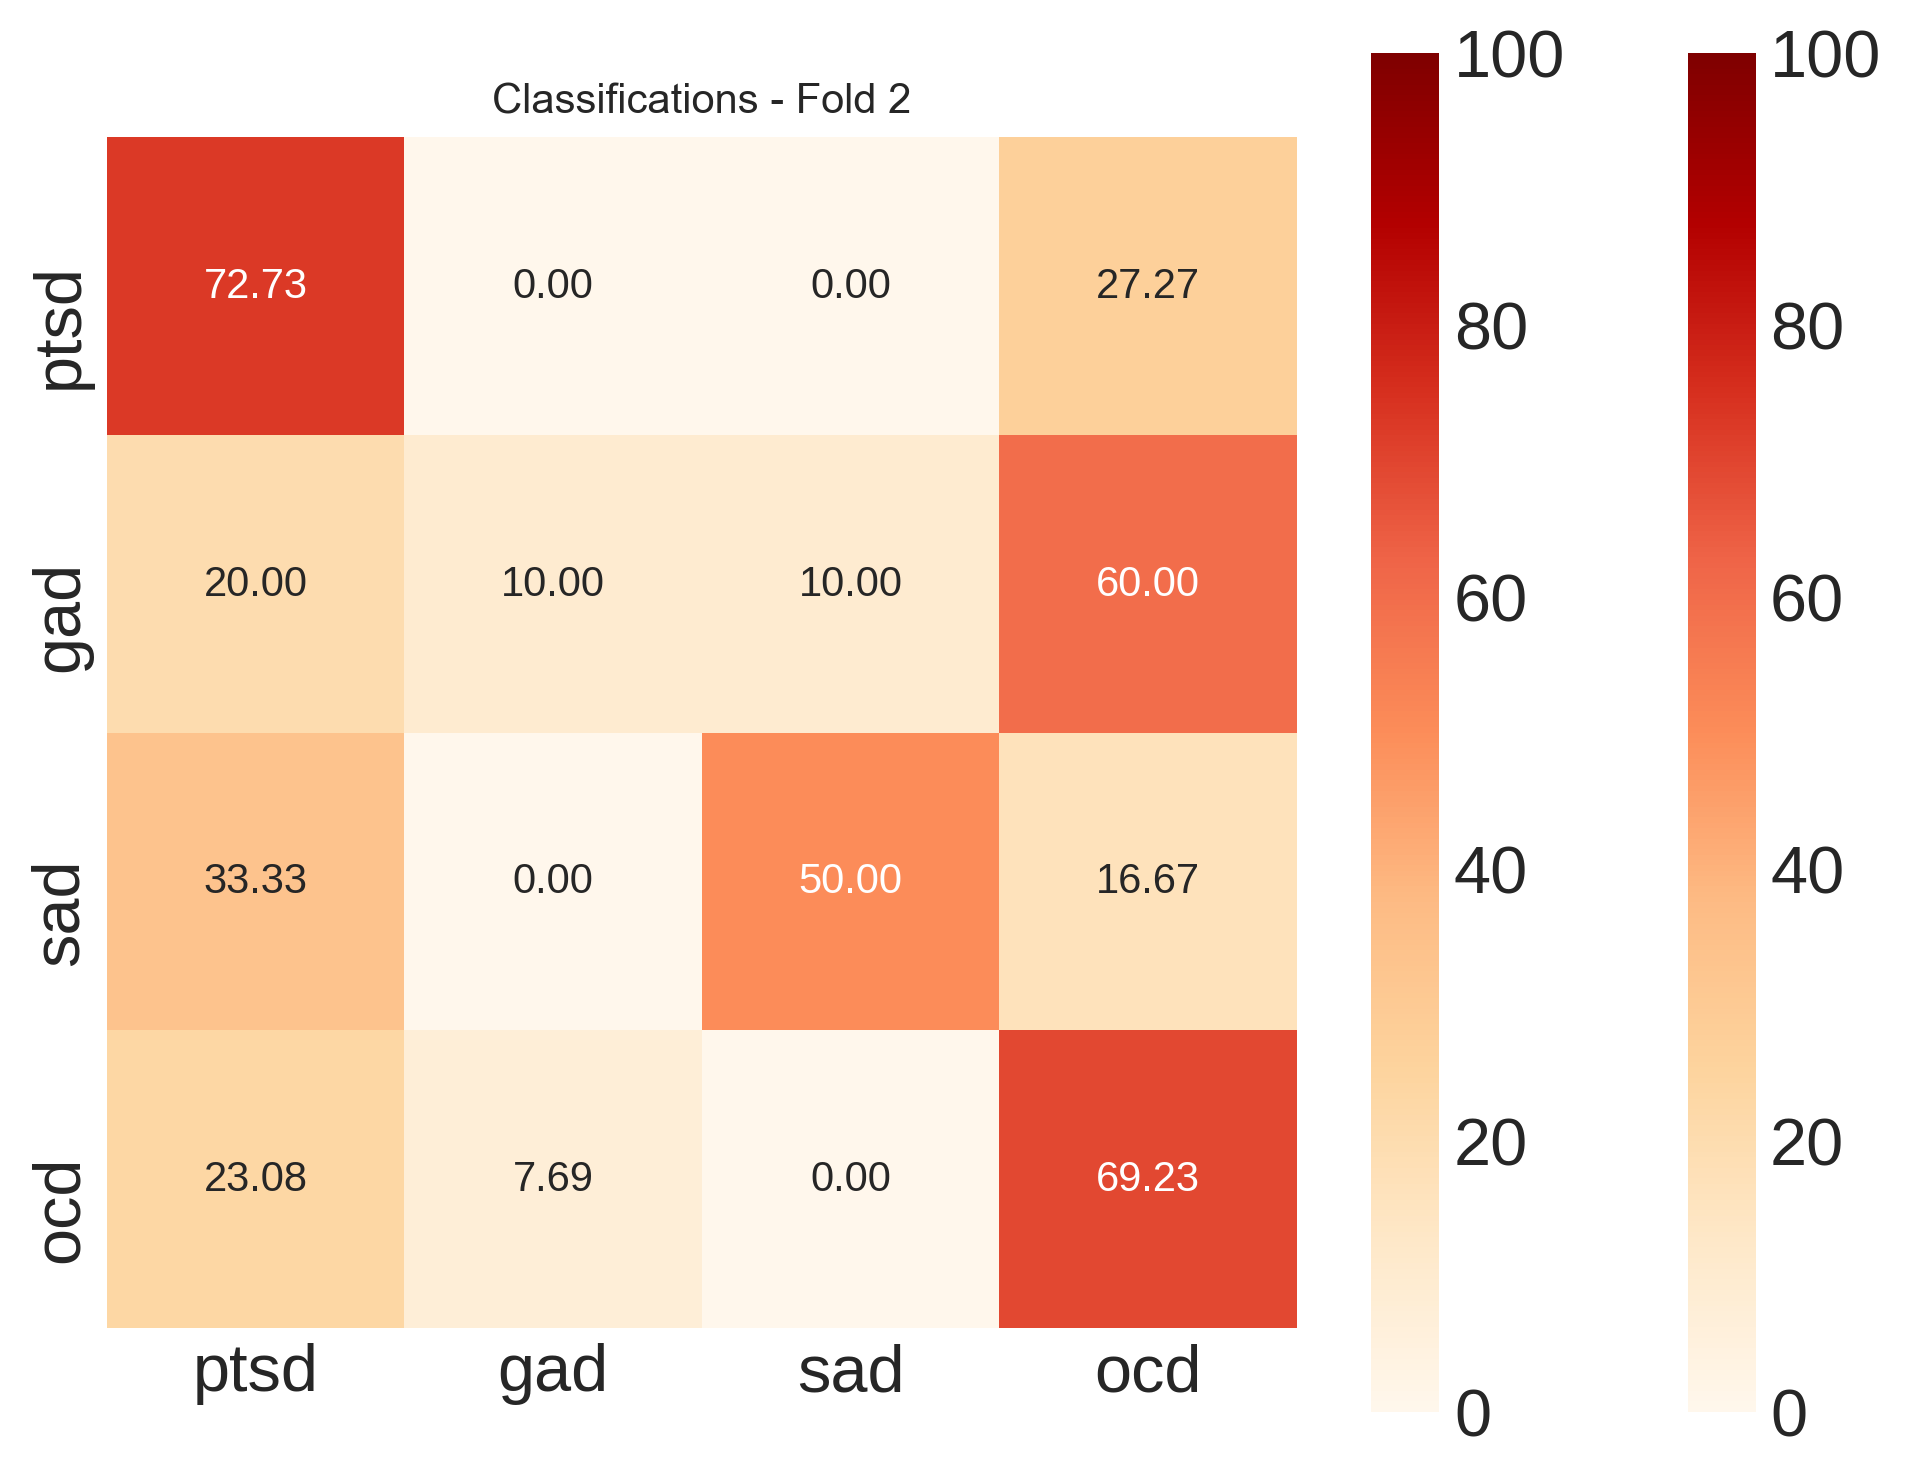

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


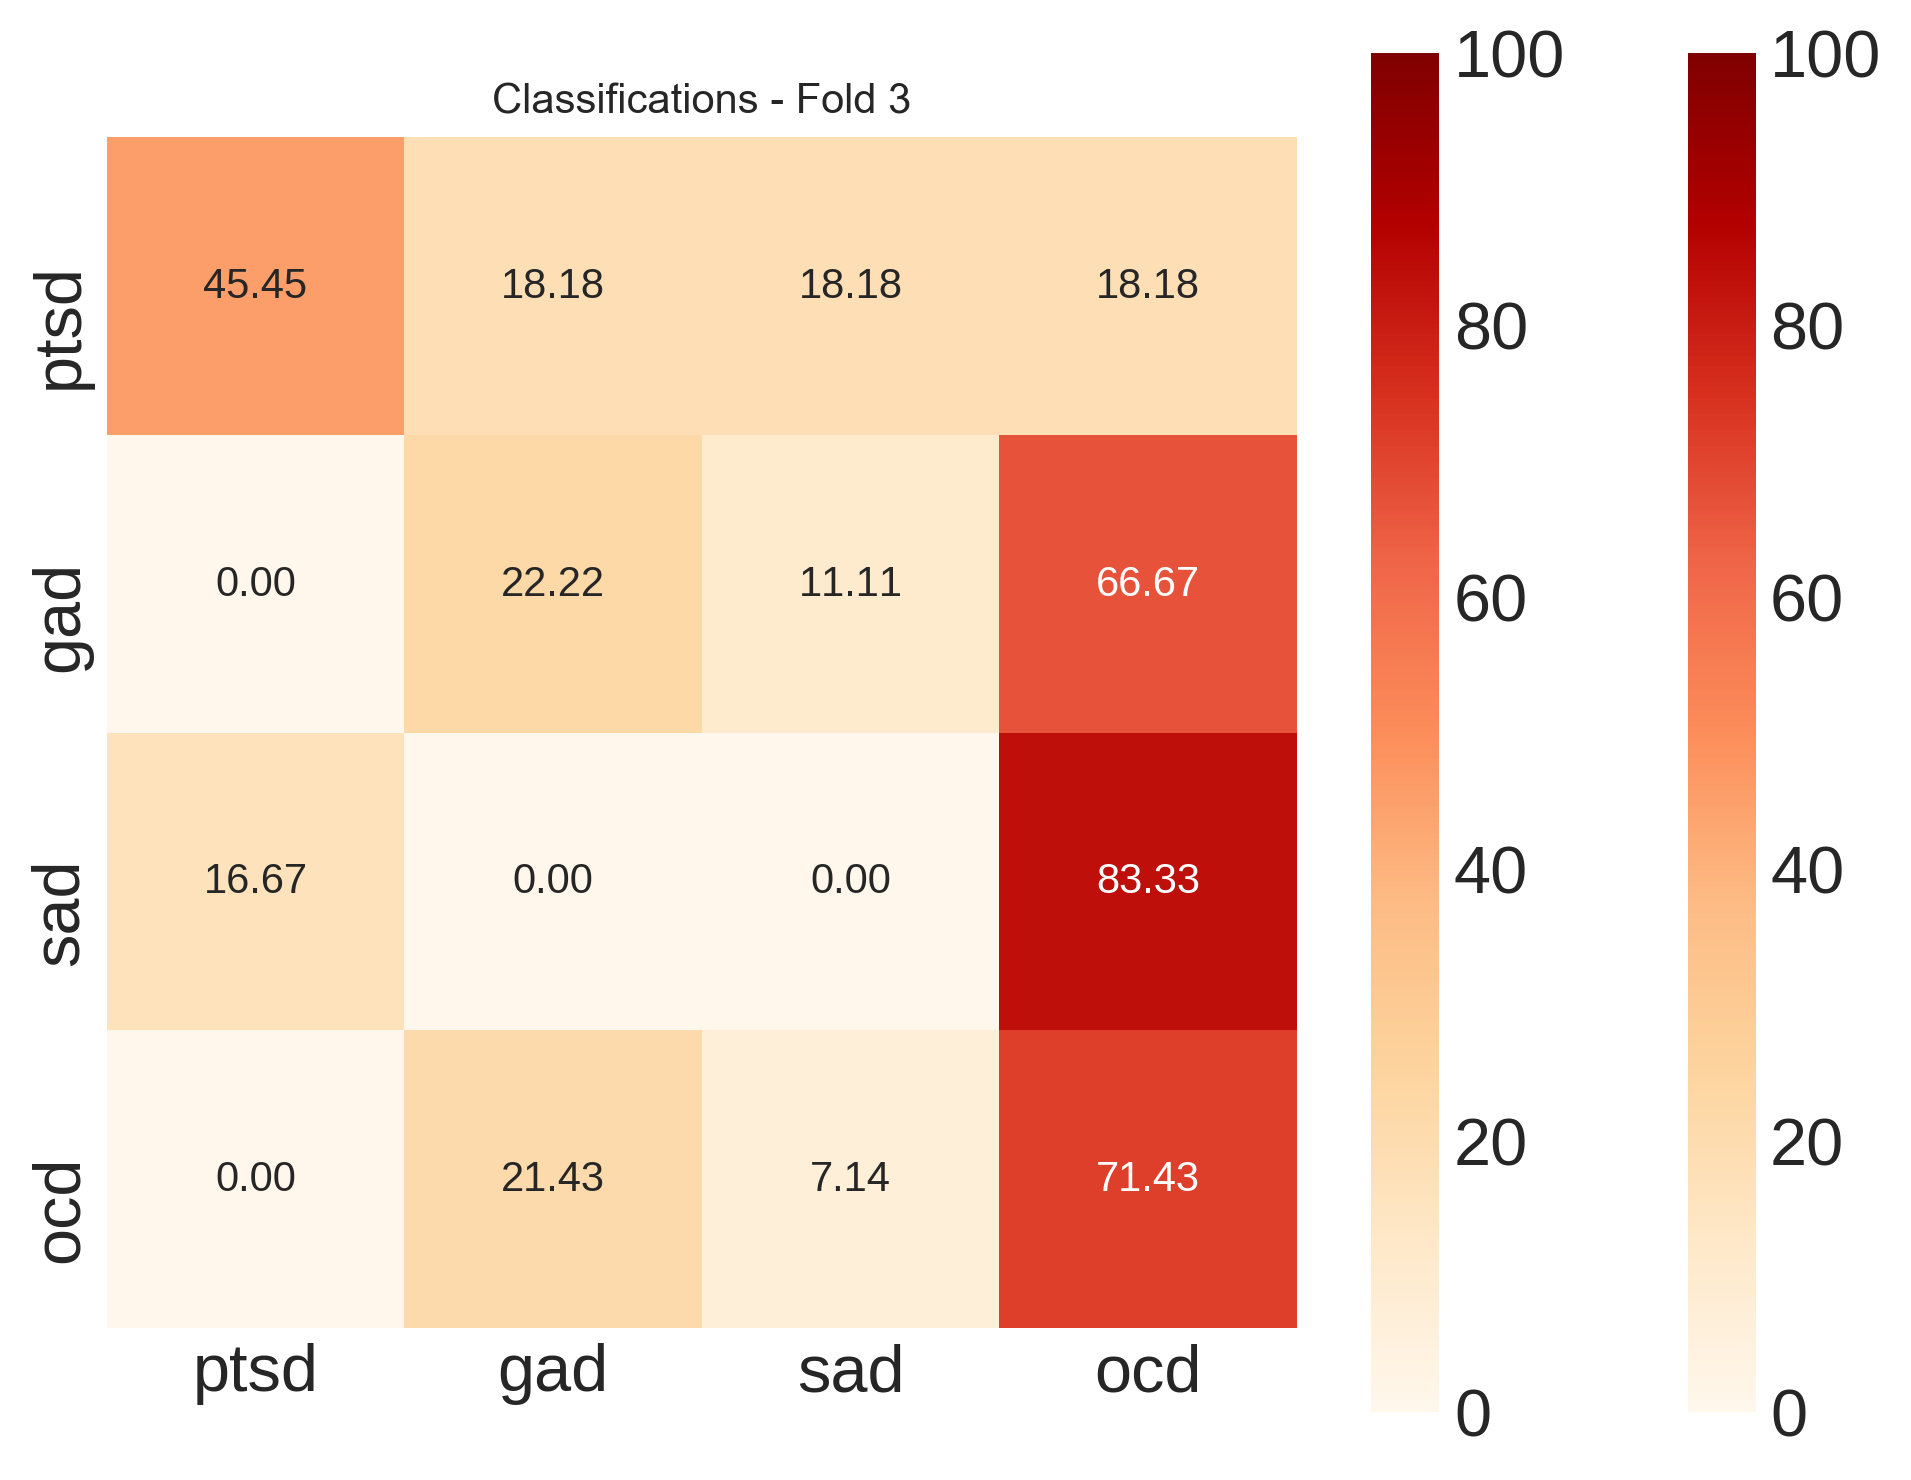

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


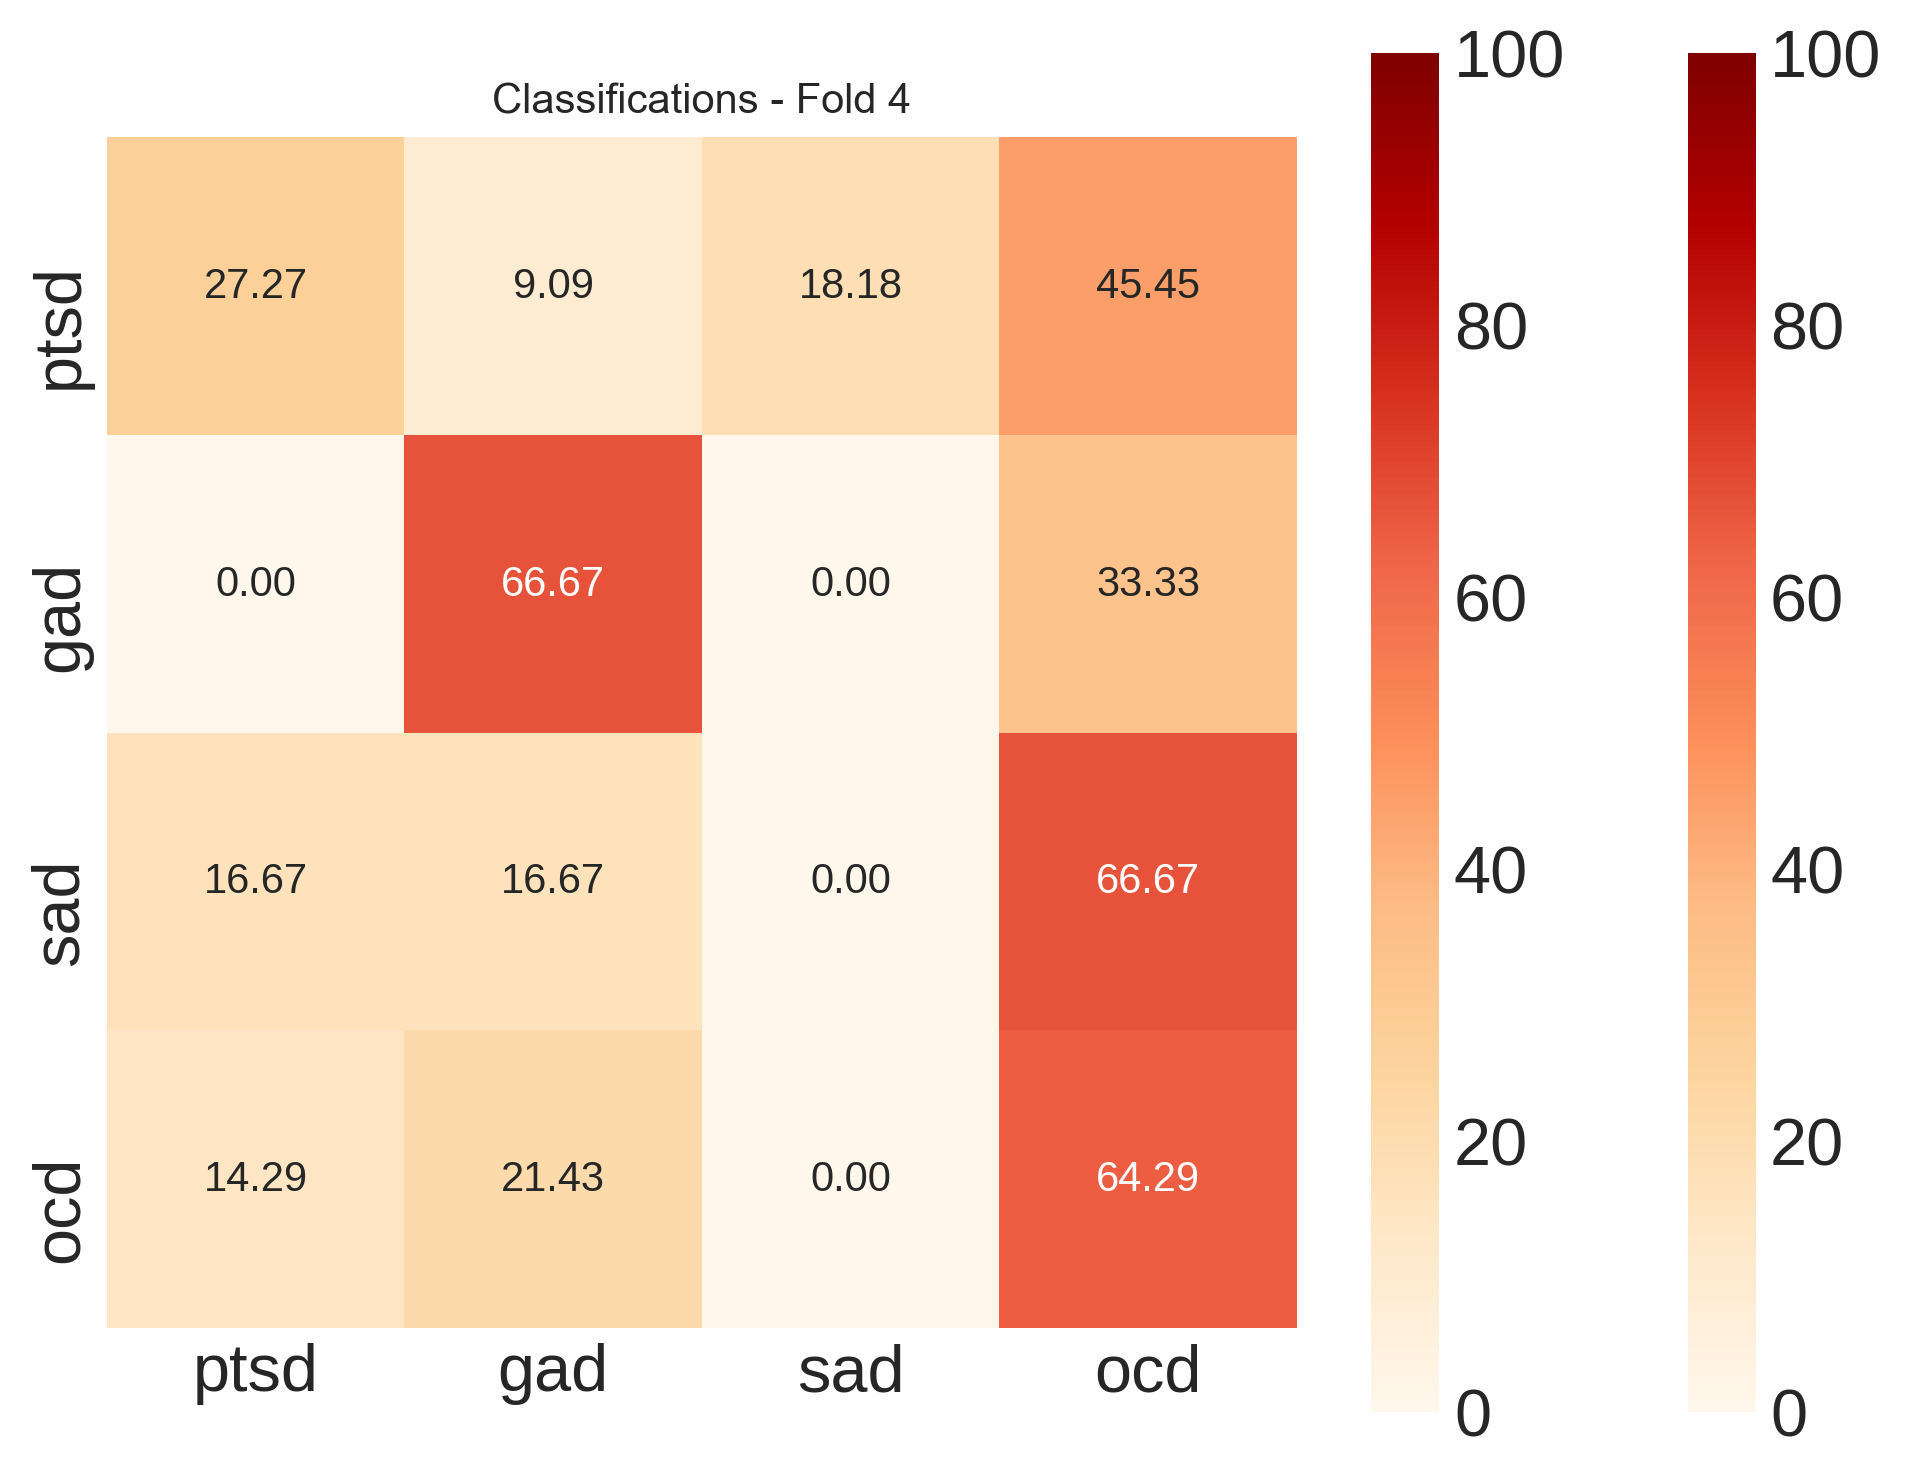

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)
/scratch/hansav/53254623.dccn-l029.dccn.nl/ipykernel_33174/3092441011.py:103: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  annot = np.zeros_like(overall_percentages, dtype=np.object)


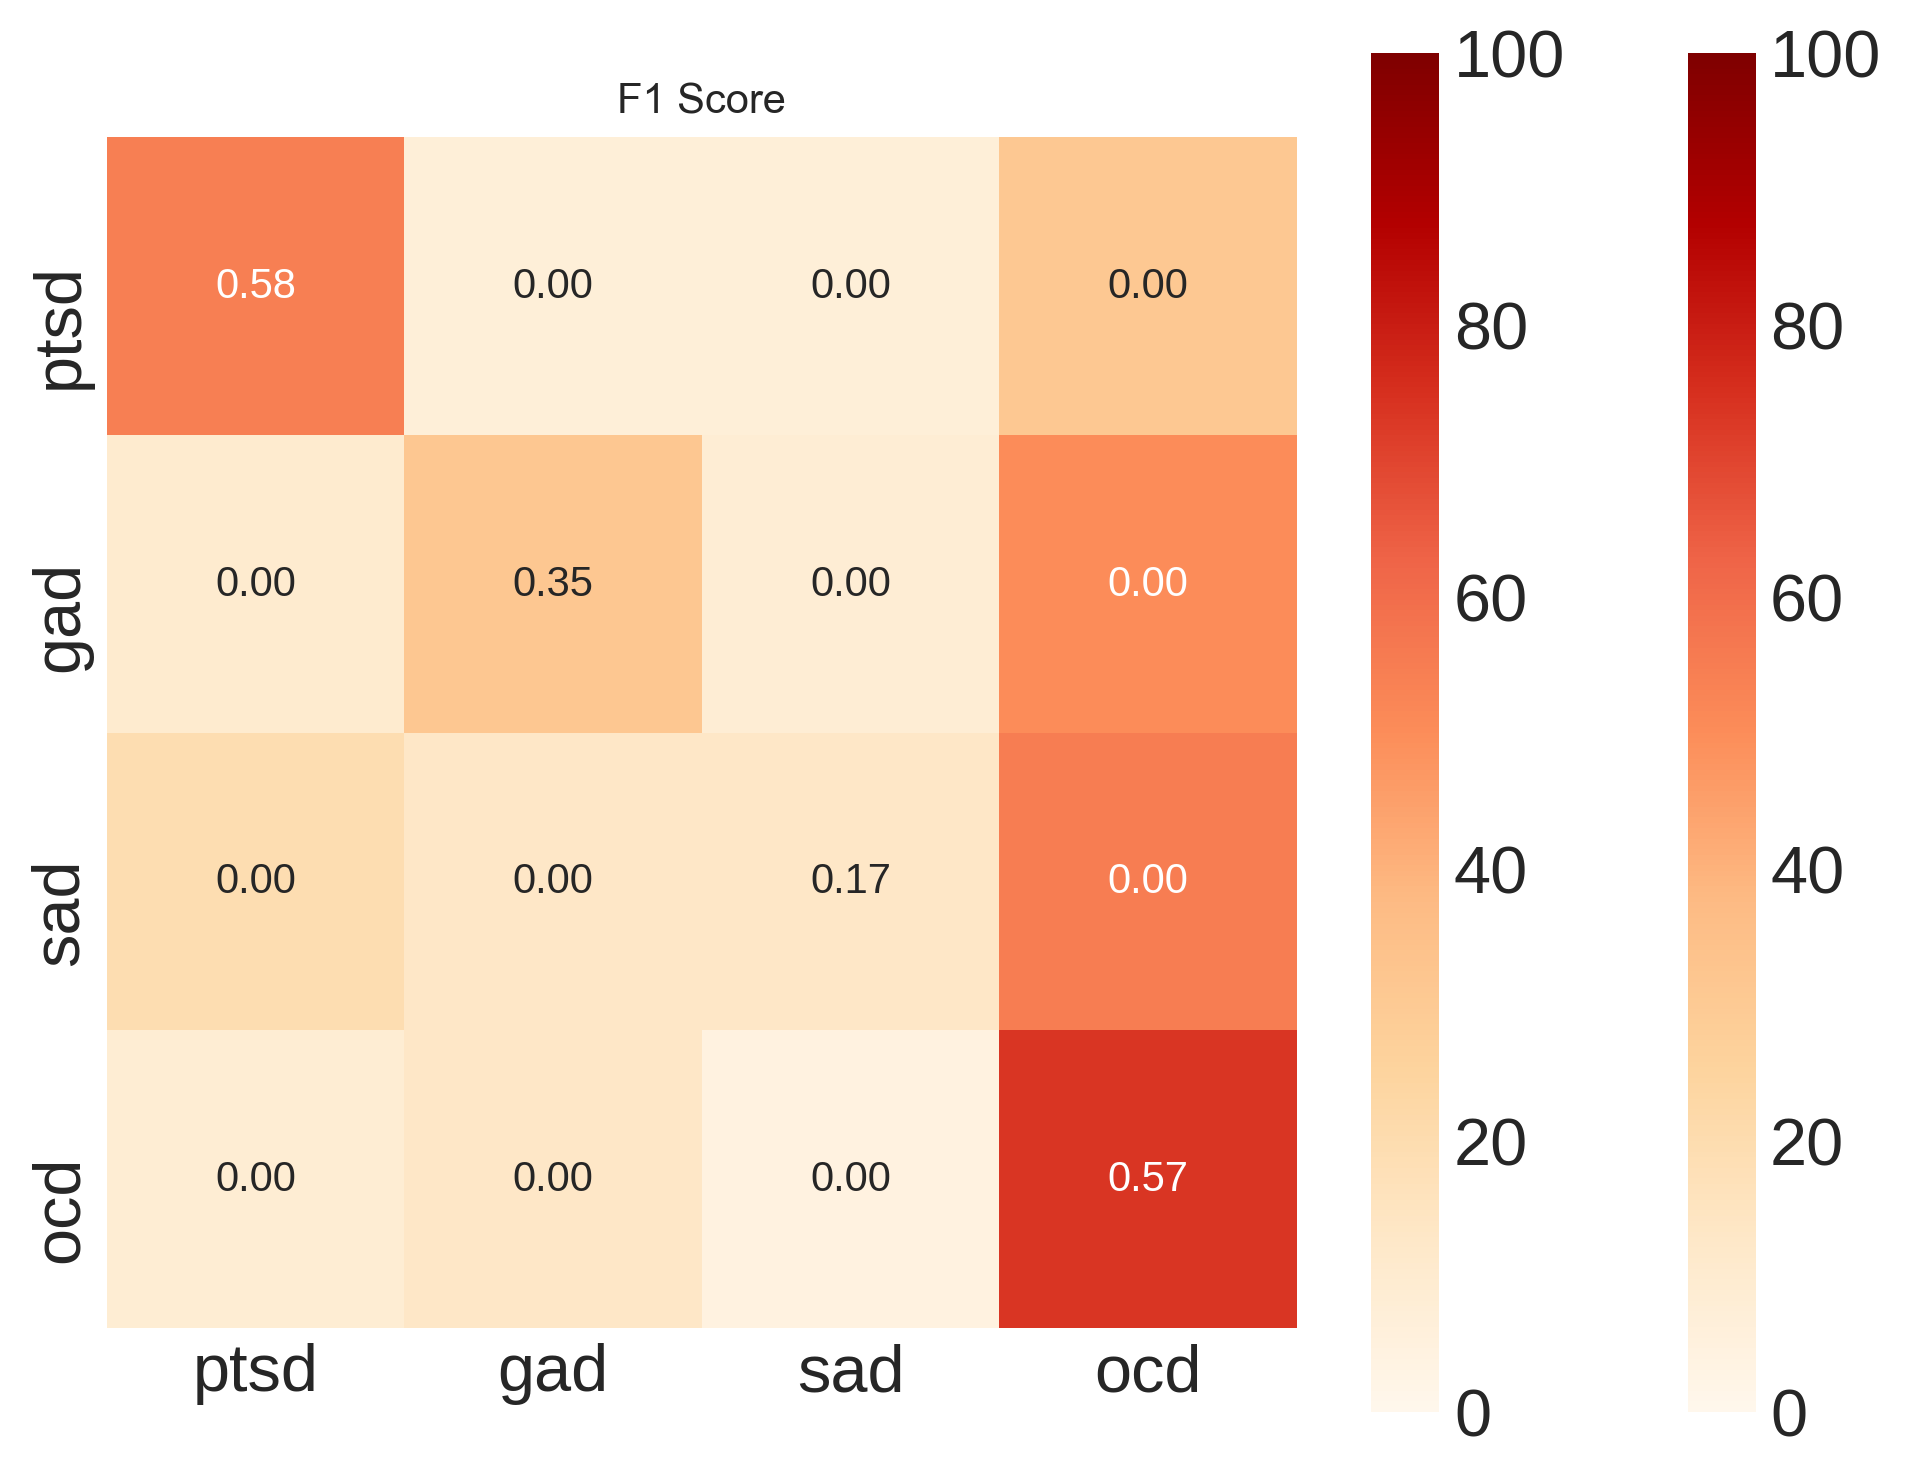

Average F1 score: [0.57676676 0.34908232 0.17       0.56748069]


In [5]:
#%% RUN CLASSIFICATION with 10-cross fold stratificiation
cv = StratifiedKFold(n_splits=5)

classifier_z = OneVsRestClassifier(estimator=svm.SVC(kernel="linear", class_weight= 'balanced'))
#svm.SVC(kernel="linear", probability=True, random_state=random_state, )

tprs_z = []
aucs_z = []
aucs_z_perms = []
mean_auc_z_perms = []
mean_fpr_z = np.linspace(0, 1, 100)
coefs_all = []
coefs_mean = []

fig, ax = plt.subplots(figsize=(15,15))
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':16,'ytick.labelsize':16,'legend.fontsize':14,'legend.title_fontsize':16}
plt.rcParams.update(parameters)
    

#%% Run classifier and plot confusion matrix

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl", 9)
# Set up the font path
fpath = Path("/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")
#sns.set(font==fpath)

plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300

# Assuming your class labels are as follows
class_labels = [1, 2, 3, 4]
class_full = ['ptsd', 'gad', 'sad', 'ocd']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classifier_z = OneVsRestClassifier(estimator=svm.SVC(kernel="linear", class_weight='balanced'))

# Convert class labels to integers
y_int = y.astype(int)

# Create a custom color palette
cmap_correct = sns.color_palette("OrRd", as_cmap=True)
cmap_incorrect = sns.color_palette("PuBu", as_cmap=True)

# Initialize an empty matrix to store the overall confusion matrix
overall_cm = np.zeros((len(class_labels), len(class_labels)))

# Define the off-diagonal mask
off_diag_mask = ~np.eye(len(class_labels), dtype=bool)

cm_avg_true = []
cm_iterations_true = []
class_percentages_iterations = []

# Define lists to store F1 scores for each fold
f1_scores = []

# Iterate through cross-validation splits
for i, (train, test) in enumerate(cv.split(X1, y_int)):
    classifier_z.fit(X1[train], y_int[train])
    y_pred = classifier_z.predict(X1[test])
    cm = confusion_matrix(y_int[test], y_pred, labels=class_labels)
    overall_cm += cm
        
    # Calculate the percentage of correct predictions for each class
    class_percentages = (cm.T / np.sum(cm, axis=1)).T * 100
    class_percentages_iterations.append(class_percentages)
    
    # Plot confusion matrix for each split
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(class_percentages, annot=True, fmt=".2f", mask=~off_diag_mask, cmap=cmap_correct, xticklabels=class_full, yticklabels=class_full, vmin=0, vmax=100, square=True, ax=ax)
    sns.heatmap(class_percentages, annot=True, fmt=".2f", mask=off_diag_mask, cmap=cmap_correct, xticklabels=class_full, yticklabels=class_full, vmin=0, vmax=100, square=True, ax=ax)

    # Display class-specific percentages as annotations
    #for j, class_label in enumerate(class_labels):
    #    ax.text(len(class_labels) + 0.5, j + 0.5, f'{class_full[j]}: {np.sum(cm[j, :]):.0f}%', ha='center', va='center', fontsize=8, color='black')

    plt.title(f'Classifications - Fold {i}', font=fpath)
    plt.show()
    
    # Calculate F1 score
    f1_class = f1_score(y_int[test], y_pred, labels=class_labels, average=None)
    f1_scores.append(f1_class)

    coefs_all.append(classifier_z.coef_)
    #save the cm for this iterations   
    cm_iterations_true.append(overall_cm)
        
    #Calculate the average confusion matrix
avg_cm = overall_cm / cv.get_n_splits()
cm_avg_true.append(avg_cm)

# Calculate the overall accuracy percentage
overall_percentages = (avg_cm.T / np.sum(avg_cm, axis=1)).T * 100

fig, ax = plt.subplots(figsize=(8, 6))

f1_mean = np.mean(f1_scores, axis=0)
annot = np.zeros_like(overall_percentages, dtype=np.object)
np.fill_diagonal(annot, f1_mean)

sns.heatmap(overall_percentages, annot=annot, fmt=".2f", mask=~off_diag_mask, cmap=cmap_correct, xticklabels=class_full, yticklabels=class_full, vmin=0, vmax=100, square=True, ax=ax)
sns.heatmap(overall_percentages, annot=annot, fmt=".2f", mask=off_diag_mask, cmap=cmap_correct, xticklabels=class_full, yticklabels=class_full, vmin=0, vmax=100, square=True, ax=ax)

# Display class-specific percentages as annotations
#for i, class_label in enumerate(class_labels):
#    ax.text(len(class_labels) + 0.5, i + 0.5, f'{class_full[i]}: {np.sum(avg_cm[i, :]):.0f}%', ha='center', va='center', fontsize=8, color='black')

plt.title('F1 Score', font=fpath)
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/PD_classifier_f1_mean_4diagnosis_true.png', dpi=300)

print("Average F1 score:", f1_mean)


#np.save('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_f1.npy', f1)
np.save('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_f1_mean_true_4diagnosis.npy', f1_mean)
np.save('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_confusion_matrices_mean_true_4diagnosis.npy', cm_avg_true)
np.save('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_confusion_matrices_alliterations_true_4diagnosis.npy', cm_iterations_true)

#data_array = np.array(coefs_all)
#iterations, rows, n = data_array.shape
#count_array = np.zeros(rows,n)
#for col in range(n):
#    count_array[:,col] = np.sum(data_array[:,:,col] > 0.0001, axis =0)
                                
#ptksave(count_array, os.path.join(w_dir,'Validation/PD_classifier_count.nii.gz'), example=ex_nii, mask=mask_nii)


#out_filename = ('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_coefs_all.nii.gz')
#ptksave(coefs_all, out_filename, example=ex_nii, mask=mask_nii)

coefs_mean =  np.mean(coefs_all, axis=0) #save as nifti
out_filename = ('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_coefs_mean_true_4diagnosis.nii.gz')
ptksave(coefs_mean, out_filename, example=ex_nii, mask=mask_nii)

coefs_all_unlist = np.array(coefs_all)
coefs_cf = np.array(coefs_all_unlist)
binary_mask = (coefs_cf > 0.0001).sum(axis=0) >= 5
ptksave(binary_mask, os.path.join(w_dir,'Validation/PD_classifier_gt5_thr0001_mask_true_4diagnosis.nii.gz'), example=ex_nii, mask=mask_nii)

np.save('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_class_percentages_iterations_true.npy', class_percentages_iterations)
class_percentages_mean = np.mean(class_percentages_iterations, axis=0)
np.save('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_class_percentages_mean_true.npy', class_percentages_mean)

[[54.54545455  7.27272727  7.27272727 30.90909091]
 [10.         31.77777778  8.22222222 50.        ]
 [19.52380952 13.33333333 13.33333333 53.80952381]
 [ 8.9010989  12.96703297  4.3956044  73.73626374]]


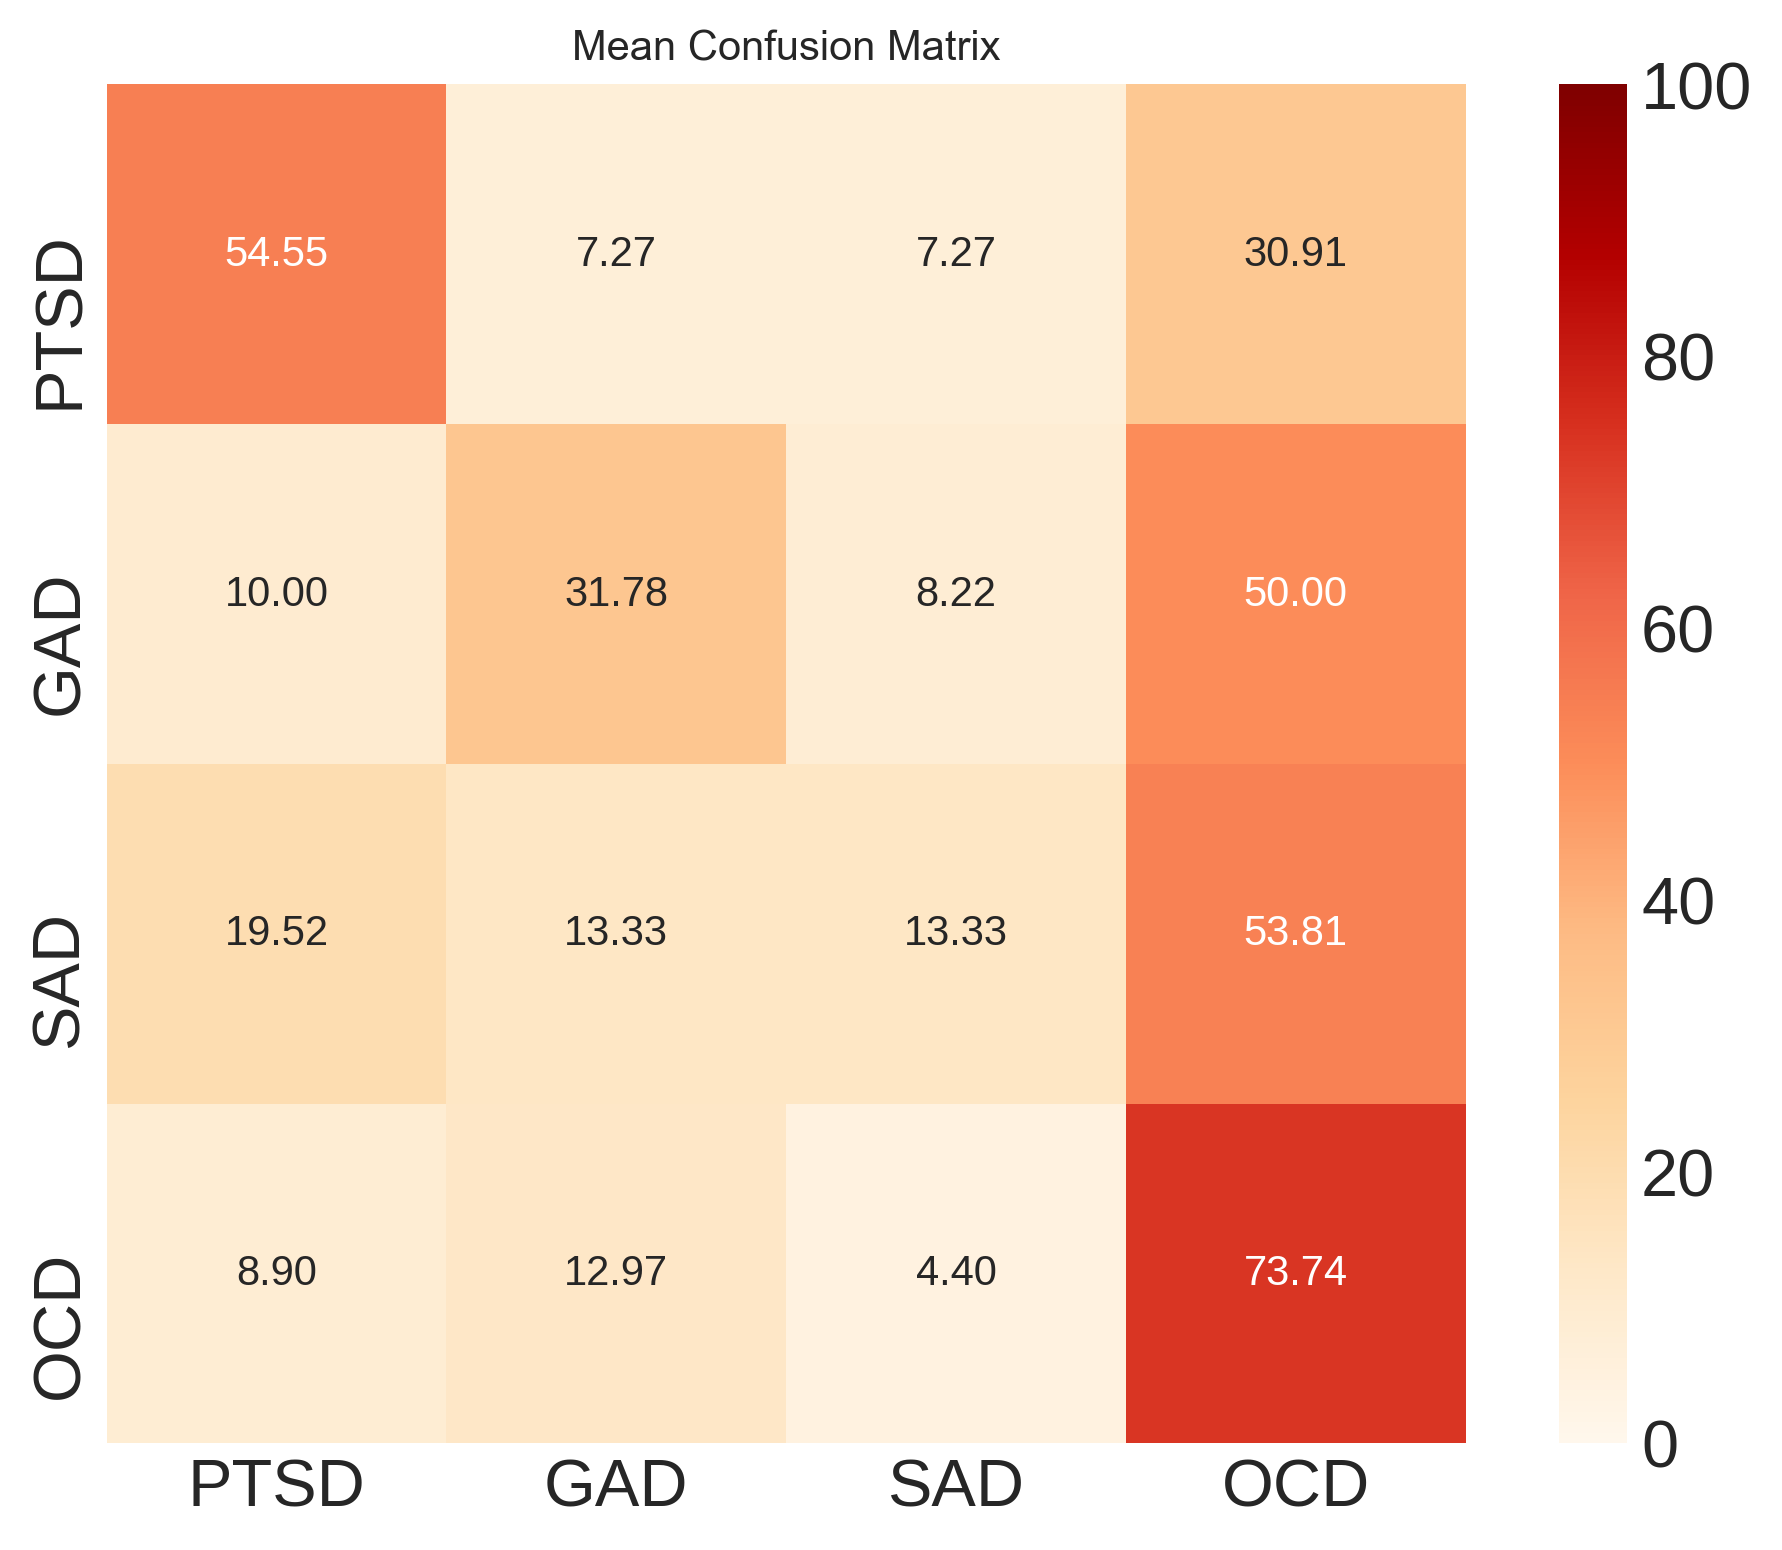

In [6]:
#Plot the mean confusion matrix
import seaborn as sns
mean_conf = np.load('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/Validation/PD_classifier_class_percentages_mean_true.npy')

print(mean_conf)
sns.set_style("whitegrid")
sns.set_palette("husl", 9)
# Extract the 2D confusion matrix from the 3D array
#mean_conf_2d = mean_conf[0]

sns.set_style("whitegrid")
sns.set_palette("husl", 9)

# Set up the font path
fpath = Path("/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300

# Create a custom color palette
cmap_correct = sns.color_palette("OrRd", as_cmap=True)

# Assuming your class labels are as follows
class_full = ['ptsd', 'gad', 'sad', 'ocd']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(mean_conf, annot=True, fmt=".2f", cmap=cmap_correct, xticklabels=['PTSD', 'GAD', 'SAD', 'OCD'], yticklabels=['PTSD', 'GAD', 'SAD', 'OCD'], vmin=0, vmax=100, square=True, ax=ax)

plt.title('Mean Confusion Matrix', font=fpath)
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/PD_classifier_classification_percentage_mean_4diagnosis_true.png', dpi=300)


In [7]:
#%% STACKED BAR CHART OF CURRENT DIAGNOSIS
mask_PDC = (Principal_diagnosis_current['Principal_diagnosis_current'].notna())
PDC_vals = Principal_diagnosis_current[mask_PDC].to_numpy()
counts = np.bincount(PDC_vals.astype(int).flatten())

# Calculate percentages
percentages = counts / len(PDC_vals) * 100

# Set up the font path
fpath = Path("/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

# Set up the figure and axis
sns.set_style("white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 1
fig, ax = plt.subplots()
# Plot the stacked bar chart
bars = ax.barh([0], [percentages[1]], color='#00c851', label='PTSD')
bars += ax.barh([0], [percentages[2]], left=[percentages[0]+percentages[1]], color='#00c465', label='GAD')
bars += ax.barh([0], [percentages[3]], left=[percentages[0]+percentages[1]+percentages[2]], color='#00bf76', label='SAD')
bars += ax.barh([0], [percentages[4]], left=[percentages[0]+percentages[1]+percentages[2]+percentages[3]], color='#00bf76', label='MDD')
bars += ax.barh([0], [percentages[5]], left=[percentages[0]+percentages[1]+percentages[2]+percentages[3]+percentages[4]], color='#F7B192', label='OCD')
bars += ax.barh([0], [percentages[6]], left=[percentages[0]+percentages[1]+percentages[2]+percentages[3]+percentages[4]+percentages[5]], color='#B9D0FA', label='SP')
bars += ax.barh([0], [percentages[7]], left=[percentages[0]+percentages[1]+percentages[2]+percentages[3]+percentages[4]+percentages[5]+percentages[6]], color='#E67259', label='PD')

# Add data labels on the right side of the bars
#for bar, percentage in zip(bars, percentages):
#    width = bar.get_width()
#    ax.annotate(f'{percentage:.2f}%', 
#                xy=(width, bar.get_y() + bar.get_height() / 2),
#                xytext=(-50, 0),  # 1 points horizontal offset
#                textcoords="offset points",
#                ha='left', va='center')

# Add labels and title
plt.yticks(font = fpath)
plt.xticks(font = fpath)
ax.set_xticks([0,100])
ax.set_yticklabels([' '])
ax.set_xlabel('Primary Diagnosis of Patients', font = fpath, size = 8)
sns.despine(top=True, left=True, bottom=True, right = True)

# Show the plot
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/PDC_PercStackedBar.png', dpi=300)

ValueError: invalid literal for int() with base 10: 'gad'